# MNIST
- 70000개의 작은 숫자 이미지의 Dataset
- Classification

In [1]:
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
from shutil import copyfileobj
from six.moves import urllib
from sklearn import datasets
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def fetch_mnist(data_home=None):
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    data_home = datasets.get_data_home(data_home=data_home)
    data_home = os.path.join(data_home, 'mldata')
    if not os.path.exists(data_home):
        os.makedirs(data_home)
    mnist_save_path = os.path.join(data_home, "mnist-original.mat")
    if not os.path.exists(mnist_save_path):
        mnist_url = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_save_path, "wb") as matlab_file:
            copyfileobj(mnist_url, matlab_file)

fetch_mnist()

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")
mnist

C:\Users\woals\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\woals\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [4]:
X,y = mnist["data"], mnist["target"]

print("train data : ",X.shape) # 28x28
print("label data : ",y.shape) 

train data :  (70000, 784)
label data :  (70000,)


5.0


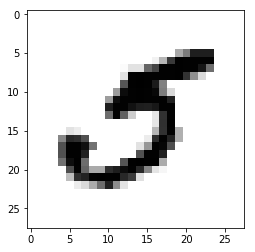

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

index = 36000

some_digit = X[index]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")

print(y[index])

In [6]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [7]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index], y_train[shuffle_index]

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(max_iter=5, random_state=42)
sgd.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd.predict([some_digit])

array([ True])

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.86105
0.9607
0.96675


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.86105, 0.9607 , 0.96675])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator): # 5가 아닌것을 찾는 추정기
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy") # False False면 정확해요

array([0.9106 , 0.90785, 0.9105 ])

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd,X_train,y_train_5,cv=3)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)



array([[51161,  3418],
       [  812,  4609]], dtype=int64)

In [17]:
from sklearn.metrics import precision_score, recall_score

print('precision : ', precision_score(y_train_5, y_train_pred)) # 정밀도 : 예측 정답이 10개인데 5개 맞았음
print('recall : ', recall_score(y_train_5, y_train_pred))       # 재현율 : 실제 정답이 10개인데 3개 찾았음

precision :  0.5741871184751464
recall :  0.8502121379819222


In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.6854550862581796

In [19]:
y_scores = sgd.decision_function([some_digit])
y_scores

array([21814.68581644])

In [20]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [21]:
threshold=200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [22]:
y_scores = cross_val_predict(sgd,X_train,y_train_5,cv=3,method="decision_function")

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

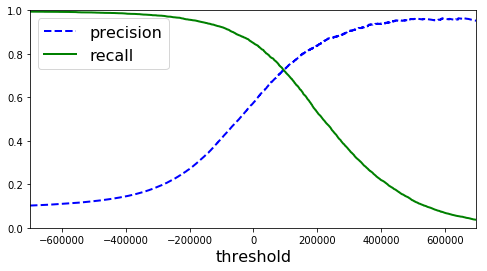

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recall", linewidth=2)
    plt.xlabel("threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [25]:
y_train_pred_90 = (y_scores > 70000)

In [26]:
precision_score(y_train_5,y_train_pred_90)

0.688090110982276

In [27]:
recall_score(y_train_5,y_train_pred_90)

0.7662792842648958

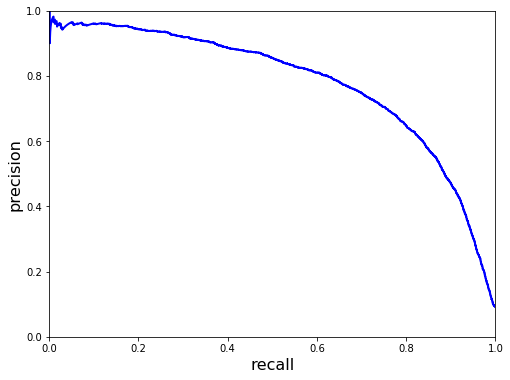

In [28]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("recall", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

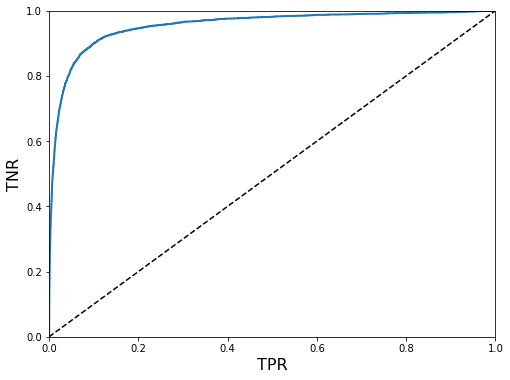

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('TPR', fontsize=16)
    plt.ylabel('TNR', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9548482798985899

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [33]:
y_scores_forest = y_probas_forest[:, 1] # 점수는 양상 클래스의 확률입니다
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

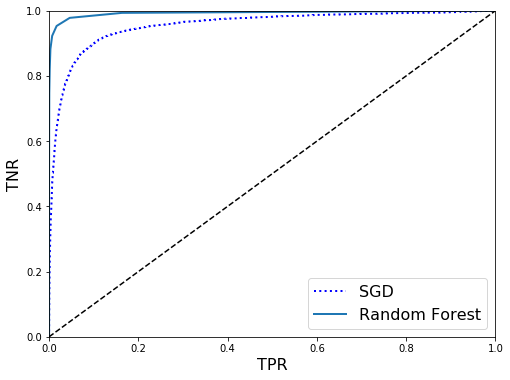

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [39]:
sgd.fit(X_train,y_train)
sgd.predict([some_digit])

array([5.])

In [38]:
some_digit_scores = sgd.decision_function([some_digit])
some_digit_scores

array([[-229767.62846677, -441563.86656571, -279734.05870953,
         -29191.47513387, -272103.89394434,   21814.68581644,
        -703449.07020296,  -51973.42546556, -766259.6010579 ,
        -605635.8931862 ]])

In [40]:
np.argmax(some_digit_scores)

5

In [42]:
sgd.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [43]:
sgd.classes_[5]

5.0

In [44]:
from sklearn.multiclass import OneVsOneClassifier
ovo = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo.fit(X_train,y_train)
ovo.predict([some_digit])

array([5.])

In [46]:
len(ovo.estimators_)

45

In [47]:
forest.fit(X_train, y_train)
forest.predict([some_digit])

array([5.])

In [48]:
forest.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0.1]])

In [50]:
cross_val_score(sgd,X_train,y_train,cv=3,scoring="accuracy")

array([0.82328534, 0.84514226, 0.86082912])

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.91071786, 0.90839542, 0.91088663])

In [54]:
y_train_pred = cross_val_predict(sgd,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5752,    3,   18,    9,   10,   43,   39,    9,   36,    4],
       [   2, 6481,   42,   24,    6,   39,    7,   12,  119,   10],
       [  57,   36, 5339,   97,   83,   21,   93,   61,  154,   17],
       [  61,   41,  139, 5313,    3,  237,   36,   55,  150,   96],
       [  19,   29,   40,   10, 5373,   10,   54,   29,   79,  199],
       [  71,   46,   34,  167,   75, 4618,  110,   29,  174,   97],
       [  32,   24,   44,    1,   42,   99, 5625,    7,   44,    0],
       [  27,   23,   66,   32,   52,   12,    5, 5803,   15,  230],
       [  61,  162,   67,  139,   14,  157,   53,   26, 5043,  129],
       [  44,   30,   32,   84,  163,   37,    2,  217,   87, 5253]],
      dtype=int64)

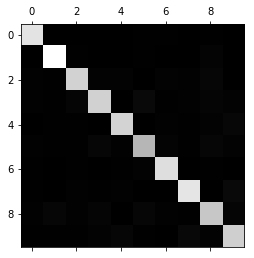

In [55]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

In [56]:
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / row_sums

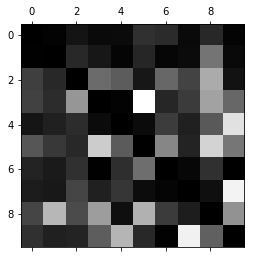

In [57]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

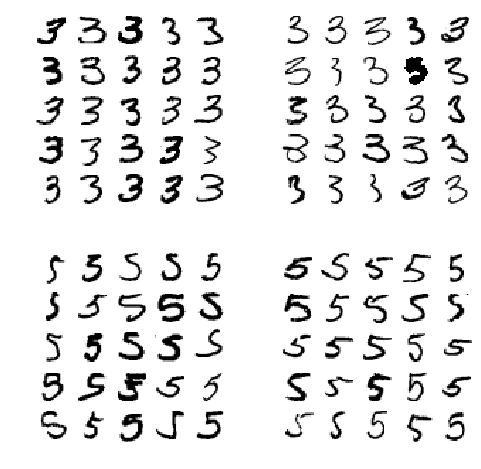

In [66]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [67]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn = KNeighborsClassifier()
knn.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [68]:
knn.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn,X_train,y_multilabel,cv=3,n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred,average='macro')

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [ ]:
knn.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)